In [ ]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

---
__UTILITY FUNCTIONS__

---

In [ ]:
def load_data(path, smoothing_present = True):
    intermediate = pd.DataFrame()
    data = pd.DataFrame()
    freq_scale = 1000000 #the frequencies as scaled by a factor 10^(6)
    rows_to_skip = 6
    i = 0
    span = 20   #window size for the smoothing
    number_of_files = len(os.listdir(path))

    #iterate over the files in the folder
    for i in range(1, number_of_files+1):
        if os.path.exists(path + f"/Data ({i}).csv"):
            df = pd.read_csv(path + f"/Data ({i}).csv", skiprows=rows_to_skip)

        #smoothing 
        if(smoothing_present):
            df['S11(DB)'] = df['S11(DB)'].ewm(span=span, adjust=False).mean()
            df['S22(DB)'] = df['S22(DB)'].ewm(span=span, adjust=False).mean()
            df['S11(DEG)'] = df['S11(DEG)'].ewm(span=span, adjust=False).mean()
            df['S22(DEG)'] = df['S22(DEG)'].ewm(span=span, adjust=False).mean()

        #exctract the rows with maximum values both of S11(DB) and S22(DB)
        row_maxS11 = df.loc[df['S11(DB)'].abs().idxmax()]
        row_maxS22 = df.loc[df['S22(DB)'].abs().idxmax()]

        #create a dataframe with the values of phase and frequency corresponding to the previus rows
        intermediate = pd.DataFrame([(pd.to_numeric(row_maxS11['Freq(Hz)'])/freq_scale), row_maxS11['S11(DB)'], row_maxS11['S11(DEG)'], (pd.to_numeric(row_maxS22['Freq(Hz)'])/freq_scale), 
                        row_maxS22['S22(DB)'], row_maxS22['S22(DEG)']])
        
        data = pd.concat([data, intermediate.T], ignore_index=True)

    column_names = ['Freq(Hz)S11', 'S11(DB)', 'S11(DEG)', 'Freq(Hz)S22', 'S22(DB)', 'S22(DEG)']
    data.columns = column_names
    print(data.shape)
    return data

In [ ]:
#values of cls = 0 (Left), cls = 1 (center), cls = 2 (Right)
#weights of the testers = 60 (Irene), 70 (Carlotta), 80 (Leo), 90 (Lorenzo)
def calculate_window_information(dataset, window_size = 50, weight=-1, step_size = 10, instances_to_skip = 150, cls=-1):
    windowed_dataset = pd.DataFrame()
    iterator = dataset.iterrows()

    for i, rows in iterator:
        #consider only the windows that must be calculated (due to the window size or the removal of the initial or final instances)
        if (i < (window_size - 1)) | (i < instances_to_skip) | (i > (len(dataset) - instances_to_skip)):
            continue

        #calculate the means
        meanFreq_MaxS11 = pd.to_numeric(dataset['Freq(Hz)S11'].iloc[i-(window_size - 1): i]).mean()
        mean_MaxS11 = dataset['S11(DB)'].iloc[i-(window_size - 1): i].mean()
        mean_S11DEG = dataset['S11(DEG)'].iloc[i-(window_size - 1): i].mean()

        meanFreq_MaxS22 = pd.to_numeric(dataset['Freq(Hz)S22'].iloc[i-(window_size - 1): i]).mean()
        mean_MaxS22 = dataset['S22(DB)'].iloc[i-(window_size - 1): i].mean()
        mean_S22DEG = dataset['S22(DEG)'].iloc[i-(window_size - 1): i].mean()

        #calculate the variances
        varFreq_MaxS11 = np.var(pd.to_numeric(dataset['Freq(Hz)S11'].iloc[i-(window_size - 1): i]))
        var_MaxS11 = np.var(dataset['S11(DB)'].iloc[i-(window_size - 1): i])
        var_S11DEG = np.var(dataset['S11(DEG)'].iloc[i-(window_size - 1): i])

        varFreq_MaxS22 = np.var(pd.to_numeric(dataset['Freq(Hz)S22'].iloc[i-(window_size - 1): i]))
        var_MaxS22 = np.var(dataset['S22(DB)'].iloc[i-(window_size - 1): i])
        var_S22DEG = np.var(dataset['S22(DEG)'].iloc[i-(window_size - 1): i])


        intermediate = pd.DataFrame([meanFreq_MaxS11, mean_MaxS11, mean_S11DEG, meanFreq_MaxS22, mean_MaxS22, 
                                    mean_S22DEG, varFreq_MaxS11, var_MaxS11, var_S11DEG, varFreq_MaxS22, var_MaxS22, 
                                    var_S22DEG, weight, cls])
        
        windowed_dataset = pd.concat([windowed_dataset, intermediate.T], ignore_index=True)

        #skip the necessary rows to jump to the next window
        for _ in range(step_size - 1):
            next(iterator, None)
            
    windowed_dataset.columns =  ['meanFreq_MaxS11', 'mean_MaxS11', 'mean_S11DEG', 'meanFreq_MaxS22', 'mean_MaxS22', 'mean_S22DEG', 
                        'varFreq_MaxS11', 'var_MaxS11', 'var_S11DEG', 'varFreq_MaxS22', 'var_MaxS22', 'var_S22DEG',
                        'Weight', 'Class']
    
    return windowed_dataset

In [19]:
def scatter_plot(df, var1, var2, tester):
    x = df[var1]
    y = df[var2]
    classes = df['Class']

    map = {0.0: 'Left', 1.0: 'Centered', 2.0: 'Right'}

    # Replace values in the array
    string_array = np.where(np.isin(classes, list(map.keys())), [map[val] for val in classes], classes)

    unique = list(set(string_array))
    
    # Assign colors based on unique values
    colors = plt.cm.get_cmap('jet', len(unique))

    for i, u in enumerate(unique):
        xi = [x[j] for j in range(len(x)) if string_array[j] == u]
        yi = [y[j] for j in range(len(x)) if string_array[j] == u]
        plt.scatter(xi, yi, c=[colors(i)], label=str(u))

    plt.xlabel(var1)  # Fix: 'set_xlabel' should be 'xlabel'
    plt.ylabel(var2)  # Fix: 'set_ylabel' should be 'ylabel'

    plt.title(str(tester))

    plt.legend()
    plt.show()

---
__PREPROCESSING__

---

In [ ]:
#The best results are obtained with smoothing of the signal
smoothing = True
step_size = 10
window_size = 50

#only for Lorenzo (the others will skip the default 150)
instances_to_skip = 500

Carlotta

In [ ]:
c_carlotta_path = "./../Dati/Centered/Carlotta"
c_carlotta = load_data(c_carlotta_path, smoothing_present=smoothing)

r_carlotta_path = "./..//Dati/Right/Carlotta"
r_carlotta = load_data(r_carlotta_path, smoothing_present=smoothing)

l_carlotta_path = "./../Dati/Left/Carlotta"
l_carlotta = load_data(l_carlotta_path, smoothing_present=smoothing)

In [ ]:
windowed_c_carlotta = calculate_window_information(dataset=c_carlotta, window_size=window_size, step_size=step_size, weight=70, cls=1)
print(windowed_c_carlotta.shape)

windowed_r_carlotta = calculate_window_information(dataset=r_carlotta, window_size=window_size, step_size=step_size, weight=70, cls=2)
print(windowed_r_carlotta.shape)

windowed_l_carlotta = calculate_window_information(dataset=l_carlotta, window_size=window_size, step_size=step_size, weight=70, cls=0)
print(windowed_l_carlotta.shape)

In [ ]:
carlotta = pd.concat([windowed_l_carlotta, windowed_c_carlotta, windowed_r_carlotta], ignore_index=True)
carlotta['Tester'] = 'Carlotta'
carlotta['Class'] = carlotta['Class'].astype(int)
print(carlotta.shape)

In [ ]:
csv_file_path = "./../Dati_unificati/carlotta_smooth.csv"
carlotta.to_csv(csv_file_path, index=False)

print(f"Data has been exported to {csv_file_path}")

Leo

In [ ]:
c_leo_path = "./../Dati/Centered/Leo"
c_leo = load_data(c_leo_path, smoothing_present=smoothing)

r_leo_path = "./../Dati/Right/Leo"
r_leo = load_data(r_leo_path, smoothing_present=smoothing)

l_leo_path = "./../Dati/Left/Leo"
l_leo = load_data(l_leo_path, smoothing_present=smoothing)

In [ ]:
windowed_c_leo = calculate_window_information(dataset=c_leo, window_size=window_size, step_size=step_size, weight=80, cls=1)
print(windowed_c_leo.shape)

windowed_r_leo = calculate_window_information(dataset=r_leo, window_size=window_size, step_size=step_size, weight=80, cls=2)
print(windowed_r_leo.shape)

windowed_l_leo = calculate_window_information(dataset=l_leo, window_size=window_size, step_size=step_size, weight=80, cls=0)
print(windowed_l_leo.shape)

In [ ]:
leo = pd.concat([windowed_l_leo, windowed_c_leo, windowed_r_leo], ignore_index=True)
leo['Tester'] = 'Leo'
leo['Class'] = leo['Class'].astype(int)
print(leo.shape)

In [ ]:
csv_file_path = "./../Dati_unificati/leo_smooth.csv"
leo.to_csv(csv_file_path, index=False)

print(f"Data has been exported to {csv_file_path}")

Lorenzo

In [ ]:
c_lorenzo_path = "./../Dati/Centered/Lorenzo"
c_lorenzo = load_data(c_lorenzo_path, smoothing_present=smoothing)

r_lorenzo_path = "./../Dati/Right/Lorenzo"
r_lorenzo = load_data(r_lorenzo_path, smoothing_present=smoothing)

l_lorenzo_path = "./../Dati/Left/Lorenzo"
l_lorenzo = load_data(l_lorenzo_path, smoothing_present=smoothing)

In [ ]:
windowed_c_lorenzo = calculate_window_information(dataset=c_lorenzo, window_size=window_size, step_size=step_size, weight=90, cls=1, instances_to_skip=instances_to_skip)
print(windowed_c_lorenzo.shape)

windowed_r_lorenzo = calculate_window_information(dataset=r_lorenzo, window_size=window_size, step_size=step_size, weight=90, cls=2, instances_to_skip=instances_to_skip)
print(windowed_r_lorenzo.shape)

windowed_l_lorenzo = calculate_window_information(dataset=l_lorenzo, window_size=window_size, step_size=step_size, weight=90, cls=0, instances_to_skip=instances_to_skip)
print(windowed_l_lorenzo.shape)

In [ ]:
lorenzo = pd.concat([windowed_l_lorenzo, windowed_c_lorenzo, windowed_r_lorenzo], ignore_index=True)
lorenzo['Tester'] = 'Lorenzo'
lorenzo['Class'] = lorenzo['Class'].astype(int)
print(lorenzo.shape)

In [ ]:
csv_file_path = "./../Dati_unificati/lorenzo_smooth.csv"
lorenzo.to_csv(csv_file_path, index=False)

print(f"Data has been exported to {csv_file_path}")

Irene

In [ ]:
c_irene_path = "./../Dati/Centered/Irene"
c_irene = load_data(c_irene_path, smoothing_present=smoothing)

r_irene_path = "./../Dati/Right/Irene"
r_irene = load_data(r_irene_path, smoothing_present=smoothing)

l_irene_path = "./../Dati/Left/Irene"
l_irene = load_data(l_irene_path, smoothing_present=smoothing)

In [ ]:
windowed_c_irene = calculate_window_information(dataset=c_irene, window_size=window_size, step_size=step_size, weight=60, cls=1)
print(windowed_c_irene.shape)

windowed_r_irene = calculate_window_information(dataset=r_irene, window_size=window_size, step_size=step_size, weight=60, cls=2)
print(windowed_r_irene.shape)

windowed_l_irene = calculate_window_information(dataset=l_irene, window_size=window_size, step_size=step_size, weight=60, cls=0)
print(windowed_l_irene.shape)

In [ ]:
irene = pd.concat([windowed_l_irene, windowed_c_irene, windowed_r_irene], ignore_index=True)
irene['Tester'] = 'Irene'
print(irene.shape)

In [ ]:
csv_file_path = "./../Dati_unificati/irene_smooth.csv"
irene.to_csv(csv_file_path, index=False)

print(f"Data has been exported to {csv_file_path}")

---
_Graphs_

---

In [ ]:
lorenzo = pd.read_csv("./../Dati_unificati/lorenzo_smooth.csv")
leo = pd.read_csv("./../Dati_unificati/leo_smooth.csv")
irene = pd.read_csv("./../Dati_unificati/irene_smooth.csv")
carlotta = pd.read_csv("./../Dati_unificati/carlotta_smooth.csv")

#create a complete dataset if needed
complete_dataset = pd.concat([irene, carlotta, leo, lorenzo], ignore_index=True)

In [ ]:
#List of possible variables:

#'meanFreq_MaxS11', 'mean_MaxS11', 'mean_S11DEG', 'meanFreq_MaxS22', 'mean_MaxS22', 'mean_S22DEG', 
#'varFreq_MaxS11', 'var_MaxS11', 'var_S11DEG', 'varFreq_MaxS22', 'var_MaxS22', 'var_S22DEG',
#'Weight', 'Class'

In [ ]:
columns_to_exclude = ["Tester"] #remove, if needed, some columns from the plot
dataset_to_plot = carlotta  #insert the dataset to plot

columns_to_plot = [col for col in dataset_to_plot.columns if col not in columns_to_exclude]

for i, col in enumerate(columns_to_plot):
    sns.boxplot(x=pd.to_numeric(dataset_to_plot[col]))
    plt.show()

In [ ]:
#mean_MaxS22
sns.boxplot(x=pd.to_numeric(carlotta['var_MaxS22']))
plt.show()
sns.boxplot(x=pd.to_numeric(leo['var_MaxS22']))
plt.show()
sns.boxplot(x=pd.to_numeric(lorenzo['var_MaxS22']))
plt.show()
sns.boxplot(x=pd.to_numeric(irene['var_MaxS22']))
plt.show()

In [ ]:
dataset_to_plot = complete_dataset  #insert the dataset to plot
scatter_matrix(dataset_to_plot, figsize = (16,16),alpha = 1,diagonal = 'hist',c = dataset_to_plot['Class'])

C:\Users\Emanuele\AppData\Local\Temp\ipykernel_11564\1958947934.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('jet', len(unique))


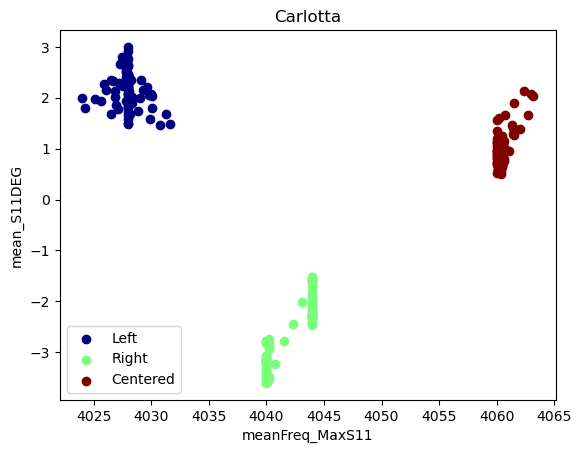

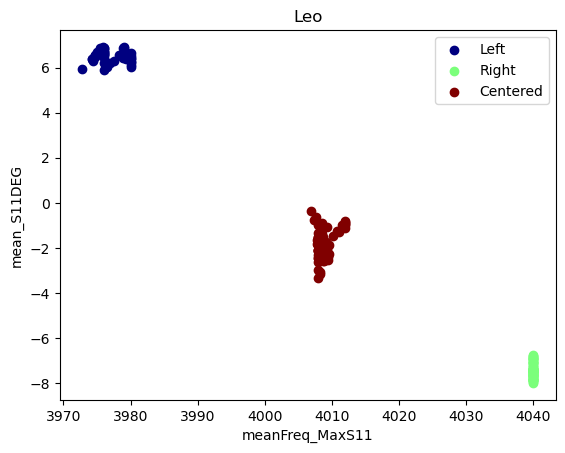

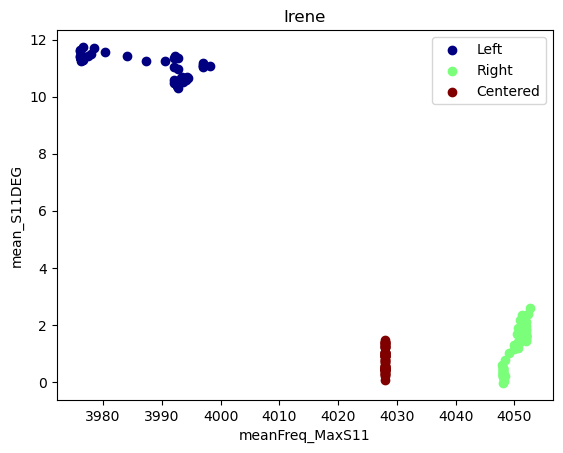

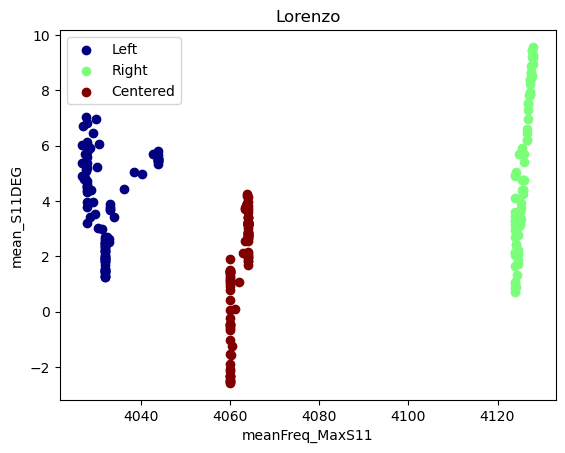

In [20]:
#insert the variables to plot
var1 = 'meanFreq_MaxS11'
var2 = 'mean_S11DEG'


scatter_plot(carlotta, var1, var2, 'Carlotta')
scatter_plot(leo, var1, var2, 'Leo')
scatter_plot(irene, var1, var2, 'Irene')
scatter_plot(lorenzo, var1, var2, 'Lorenzo')